Adapted from https://medium.com/analytics-vidhya/bert-word-embeddings-deep-dive-32f6214f02bf; most of the code is copy pasted from there.

In [140]:
import torch
import numpy as np
import pandas as pd
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel

### Setup

Load in the tokenizer and model.

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

### Tokenizer

BERT's tokenizer is a lookup table that converts words to integers. Each word is separately passed in and mapped to an integer, which is always the same regardless of the sentence. 

Some common ones:
- "[CLS]" -> 101
- "[SEP]" -> 102
- "i" -> 1045
- "the" -> 1996

In [4]:
# Define an input text
text = "Here is the sentence I want embeddings for."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
here          2,182
is            2,003
the           1,996
sentence      6,251
i             1,045
want          2,215
em            7,861
##bed         8,270
##ding        4,667
##s           2,015
for           2,005
.             1,012
[SEP]           102


### Embeddings

In [5]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Run the text through BERT, get the output and collect all of the hidden states produced from all 12 layers.
with torch.no_grad():
    outputs = model(tokens_tensor)    
    hidden_states = outputs[2]
    
# Many ways to create the embedding from the hidden states. The two most effective according to the post
# are summing last 4 hidden states (giving 768-dim vector) and concatenating them (giving 3072-dim vector).
# However, based on the competition notes, it seems like they just use the last hidden layer outputs.
word_embed = hidden_states[-1]
print(word_embed.shape)

torch.Size([1, 14, 768])


To make this less tedious, I'll just make a single function to handle this.

In [6]:
def get_embedding(sentence):
    # Tokenize
    marked_text = "[CLS] " + sentence + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    # Get word embeddings
    tokens_tensor = torch.tensor([indexed_tokens])
    model.eval()
    with torch.no_grad():
        outputs = model(tokens_tensor)    
        hidden_states = outputs[2]
    return hidden_states[-1]

In [141]:
clean_sentences = {
    "000000024976": {
        "data": "Don't waste 90 minutes of your time on \"Fast Food, Fast Women.\" It's annoyingly episodic script with three story lines patched together is laughably bad due to predictable writing, horrific acting, and even bad music. I found the anorexic main character upsetting to watch every time she was on screen. SHE needs the fast food.<br /><br />Spend the 90 minutes you'd devote to this turkey doing something more exciting...like trimming your toenails. You'd have more entertainment value.<br /><br />The only redeeming thing about this film is Louise Lasser, but she deserves much better than this tired script. It's as impotent as the elder guy she courts in the movie.<br /><br />VIEWER BEWARE!",
    "label": 0
  },
  "000000024977": {
    "data": "This movie was billed as a comedy and a mystery. It fails badly at both. The only mystery here is why would anybody make such a poorly constructed movie. The only comedy is the laugh I got when I saw how high the readers here ranked it. Could there be two movies with the same name? The movie I saw starred a girl with pretty blue eyes and a plot that wasn't there.<br /><br />",
    "label": 0
  },
  "000000024978": {
    "data": "Story starts slow and nothing funny happens for a while. All the action is in the end, but you won't have to laugh because the movie is funny, but because the story is pathetic.<br /><br />The funniest part is when Harvey 'I'm not Paranoia' Keitel really loses it and the judge starts a massacre. Oscars for this guy!",
    "label": 0
  },
  "000000024979": {
    "data": "This film is a massive Yawn proving that Americans haven't got the hang of farce. Even when it has already been written for them! The original film \"Hodet Over Vannet\" is a witty comedy of errors that I would rate 8/10. It isn't just about a linguistic translation, but certain absurd chains of events are skipped entirely, robbing the film of its original clever farcical nature and turning it into a cheap \"oops there go my trousers\" style of farce.",
    "label": 0
  },
  "000000024980": {
    "data": "It was a Sunday night and I was waiting for the advertised movie on TV. They said it was a comedy! The movie started, 10 minutes passed, after that 30 minutes and I didn't laugh not even once. The fact is that the movie ended and I didn't get even on echance to laugh. PLEASE, someone tickle me, I lost 90 minutes for nothing.",
    "label": 0
  },
  "000000024981": {
    "data": "Have I ever seen a film more shockingly inept? I can think of plenty that equal this one, but none which manage to outdo it. The cast are all horrible stereotypes lumbered with flat dialogue. I am ashamed for all of the people involved in making this. Each one wears an expression of fear not generated by the plot, but by the realisation that this project could easily nix their career. Even the many charms of Ms. Diaz don't provide an adequate reason to subject yourself to this. Avoid, it's obviously a style of film that Americans haven't really got a grasp of. Watch the final result if you must, and you'll see what I'm talking about, but DON'T say I didn't warn you...",
    "label": 0
  },
  "000000024982": {
    "data": "The next time you are at a party and someone asks, \"The other day I heard the expression 'Author's will'. Does anyone know what it means?\" Tell them to sit through 'Head Above Water'. The only way Diaz could possibly have survived this movie was by means of this literary device commonly used by bad writers. There are some comic scenes and you will have a few laughs. However the film does not stand up to the most minor logical analysis. Why does Keitel tie Diaz's hand in front of her instead of behind? Why so she can do the chainsaw gag of course. For me the best part of this movie was that I saw it on a cable channel instead of spending four bucks at the video shop.",
    "label": 0
  },
  "000000024983": {
    "data": "Turgid dialogue, feeble characterization - Harvey Keitel a judge? He plays more like an off-duty hitman - and a tension-free plot conspire to make one of the unfunniest films of all time. You feel sorry for the cast as they try to extract comedy from a dire and lifeless script. Avoid!",
    "label": 0
  },
  "000000024984": {
    "data": "Cameron Diaz is a woman who is married to a judge, played by Harvey Keitel, whose life is fine until an ex shows up and things get a little complicated.. While I was watching this movie there were several times i asked myself why I was doing so..because the movie is so ridiculous and blah and poorly scripted without any believability. Nor does the audience really car what happens..Even the lovely Cameron can't save this one on a scale of one to ten..2",
    "label": 0
  },
  "000000024985": {
    "data": "I had the misfortune to watch this rubbish on Sky Cinema Max in a cold winter night. I am not a big fan of horror movies, because most of them are just trash. This one is even worse: it is one of the dumbest pieces of crap i've ever seen in my whole life. Horror movie? Yes, there are horrible things in this: the acting, the script and the special effects - Gosh, i laughed at this ludicrous attempt to make a flick for 90 minutes. Actually, had it been a comic movie i would've given it a 5. Don't you even think about renting this unless you want to mock at the producers.<br /><br />Vote: 2 out of 10 - didn't vote one because it made me laugh all the time ;-)",
    "label": 0
  },
  "000000024986": {
    "data": "It's pretty bad when the generic movie synopsis has more information than the film itself. The paragraph-long \"plot summary\" written on the movie page has details I could not glean from watching the actual movie. I found myself constantly backing it up to see what details I had just missed which could tell me what the (bleep) was going on. Alas, to no avail--this movie leaves out monstrous pieces of the story, if you could call it a story. It's like they were trying to fool us into thinking that there was some kind of movie here, filming just enough so that there was the resemblance of a story and leaving the rest to our imaginations. Newsflash to the the creators: I paid to watch you MAKE a movie. I can sit home and imagine plots and story lines for free. And Rosario Dawson? This is somebody I've never paid enough attention to to be able to put the name to the face, and I can see why. She had one of the most artificial performances I have ever seen for a leading character in any movie, A or B. I figured okay, maybe she didn't really want the role, just got a hefty offer for a movie she wasn't into? Wrong. She was listed as one of the producers. Next time you produce something, don't book yourself as the lead if you can't act. If you really can, then create a decent character for you to become. Also, somebody here mentioned the white/latino issue--yes, I hate to say it, but this movie does come across as an act of vengeance against white college-age males who wear baseball hats. That's what happens when there is nothing in the movie to endear the watcher to latino characters. The Adrian character seems like a cocky jerk who is no better than the story's antagonist. As for the Maya character, she didn't seem like a real person. Anyway I'm ashamed for Hollywood that this movie was even made.",
    "label": 0
  },
  "000000024987": {
    "data": "Having watched this movie on the SciFi channel, I can only conclude that this film was made by a bunch of amateurs who have never seen a movie in their lives. The film is an endless sequence of bizarre occurrences, or \"delights\" as the friend reading over my shoulder is telling me. The plot isn't really worth commenting as, but basically a plane carrying football players crashes into Yeti territory. Before the movie is over, we are treated to yetis ripping hearts out, yetis waddling in an effort to run before jumping 50 meters, yetis ripping a man's legs off and beating him with them, a woman killing a rabbit at 30 meters with a javelin, a yeti surviving several bullets and being set on fire with no apparent harm, a yeti dangling off a cliff by holding to a man's shoe, yet then jumps off, and a whole collection of further, bizarre occurrences. Basically, if you aren't staying up on a Saturday for the expressed purpose of watching the worst of SciFi channel original movies, avoid this film like the plague. Or as my friend reading over my shoulder says: \"It's the best movie I have ever seen.\" To which the friend on my right says: \"Only battle techno music could have made it better.\"",
    "label": 0
  },
  "000000024988": {
    "data": "First off, I'm not here to dog this movie. I find it totally enjoyable in spite of the poor production quality. The acting herein is about as abominable as the monster stalking them, although the monster itself is quite well done...impressively well done, at that. He actually looks kind of other-worldly, like an alien family on vacation landed in the Himalayas and while dad was out taking a ... attending to nature's call, Spot got loose and they just didn't have time to hunt him down. That, or he's the Caucasian brother of the Wishmaster. I haven't decided which.<br /><br />Actually, this seems to have been filmed somewhere in snow country, yes, but more likely Canada somewhere than China anywhere. The trees and vistas say Canada to me, and it's okay that the set area never takes on the look or feel of uber-coldness one might expect to find in the Himalayas of China. It's a Sci-Fi Channel movie, so we can forgive the lack of location.<br /><br />Further, apparently (as we have just established) Sci-Fi directors do not travel often, as they are not aware that commercial planes fly above weather like what is featured herein and the subsequent crash actually would not have happened. But as I said, it's a Sci-Fi Channel movie so we must forgive a few things.<br /><br />The movie is pretty graphic at times, and rotates between \"Alive\" about the Donner Party, \"Predator\" about the alien in the woods, and any bad wushu movie where they fly about on wires. The Yeti apparently can leap about like Spiderman...or Super Mario...remember? \"Run faster! Jump higher! Live longer!\" <br /><br />Also, the Yeti has missed his teddy bear. He's searched high and low for it, but cannot seem to make a cadaver work. Poor Yeti! You can't help but feel sorry for it. It has survived and evolved thousands of years only to succumb to severe teddy bear loss. He's missed his bear. Or maybe it wants to mate, but that thought is BANISHED! Do ya hear me? Well, it does seem to be an unmated male. REBANISHED! <br /><br />And it's superhuman. Well, it's not human...it's super-Yeti! But then again, what's normal-Yeti? I don't know, but he has a definite Michael Meyers quality that is completely unsettling. And he's got this fabulous way of cleaning his fur. FABulous Dahlink! It's spotlessly white at times when it SO shouldn't be. He's fastidiously superhu-...super-Yeti.<br /><br />All in all? This was a lot of fun to watch, has some great kills and a few honest plot elements. In spite of the horribly gravel-like production style, this is actually quite entertaining. I can't help wondering if they're planning on another one? <br /><br />It rates a 6.0/10 on the M4TV Scale.<br /><br />It rates a 4.4/10 on the Movie Scale from...<br /><br />the Fiend :.",
    "label": 0
  },
  "000000024989": {
    "data": "Ah yez, the Sci Fi Channel produces Yeti another abominable movie. I was particularly taken by the scenes immediately following the crash where, as the survivors desperately searched for matches, at least a half dozen fires burned \u0096 with no apparent reason \u0096 at various points of the wreckage. Fire seemed to be a predominate theme throughout. They searched corpses for lighters and matches, and finally finding a box built a fire every day for, apparently, 12, but no one ever gathered wood. Then when the vegan (hah) burned the bodies, what did she use for an accelerant? I mean these guys were frozen \u0096 well maybe not. Despite the apparent low temperature everything the yeti ate, bled. Maybe it's just me, but even in a totally unbelievable tale (none of the survivors had ever heard of a yeti, or an abominable snowman, until the very end), if you take care of the little things the bigger deals become more acceptable. Oh, what did the prologue (1972) have to do with the remainder of the movie? And the revolver, warm enough to hold in his hand, froze up and wouldn't fire. Gimme a break. Well, at least we have Carly Pope, another eminently lovely Canadian lass. And, with little irony, Ed Marinaro as the coach.<br /><br />Well I might as well add, the rabbit they ate (despite it looking like chicken) is not a rodent, but a lagomorph. Now if it had been a squirrel (or a rat) it would have been a rodent, but it still looked like chicken. And the writers missed a real chance to have someone note \"It tastes just like...\"",
    "label": 0
  },
  "000000024990": {
    "data": "Yeti: Curse of the Snow Demon starts aboard a plane full of American high school teens who are on their way to play a football game in Japan, unfortunately during a fierce thunder storm their plane crashes in the Himalayas. Unlucky really. With some dead & some alive the survivors have to think about themselves & decide to wait it out until help comes. However just when they think their luck couldn't get any worse they soon discover that a huge, hairy Yeti type Abominable Snowman creature wants to kill & eat them all. Trapped, cold, starving & fighting for survival will help reach the stranded teens in time?<br /><br />Yeah, with a title like Yeti: Curse of the Snow Demon it can only mean one thing & that is that someone at the Sci-Fi Channel has made yet another 'Creature Feature' although to give these things a bit of variety the Sci-Fi Channel here in the UK are now dubbing them as a 'Beast Feast'! As if that will make any difference. Directed by Paul Ziller one has to say that Yeti: Curse of the Snow Deamon is a terrible film but a somewhat entertaining one at the same time, sure it's bad but it's sort of fun at times too. The basic premise is alright actually, it's a sort of cross between Alive (1993) with it's plane crash & the survivors having to turn cannibal to survive & the excellent gory killer Bigfoot (another legendary hairy monster) exploitation flick Night of the Demon (1980) which I would defend with my last breath & I have to say it's not exactly a marriage made in heaven but as I said it's fun at times if not exactly gripping or well written. The character's are mostly annoying American teens, there's the expected arguing, there's the macho hero, the strong female & the coward who thinks only of himself so there's no prizes for originality. There are some plot holes too, if a plane load of people crash why only send two rangers on foot to search for them? How are you going to dig a large hole & line it with sharpened sticks in the space of ten minutes? Why did the Yeti not kill that bird at the end? It had killed everyone else up to that point so why not her? The 'there are actually two Yeti's running around' twist isn't used to any effect at all either. At least there's a good pace about the film, it certainly moves along at a fair old pace & I never found myself becoming bored with it. There's some moderately gory action & the film does have some fascination in seeing whether the kids are going to survive or not & if they are going to eat their dead mates or not.<br /><br />The one thing you can always say about these Sci-Fi Channel 'Creature Features' or 'Beast Feasts' is that the CGI computer effects will be laugh out loud hilarious & so that proves to be the case yet again. The plane crash at the start looks awful & the Yeti when it's CGI looks simply embarrassing jumping all over the place like it's on a pogo stick. There one or two nice gore scenes including a ripped off arm, a squashed head, a ripped out heart, some dead bodies, some blood splatter & the best bit when the Yeti rips a guy in half & beats him with his own ripped-off legs before biting a big chunk out of them. According to the IMDb the actor playing the Yeti took three & a half hours to get into the suit & the make-up which seems like a long time since it's actually a pretty tatty looking creation. Apparently the original title was Raksha: Curse of the Snow Demon with Raksha meaning demon in Tibetan Sanskrit, so now you know.<br /><br />This has reasonable production values considering the usual Sci-Fi Channel stuff they churn out although the mountain location looks nothing like the harsh, bleak Himalayas & was probably situated near some ski resort somewhere & during a lot of the daytime scenes it actually looks pleasantly warm. The acting isn't that good & I didn't think any of the girls looked that good either which didn't help.<br /><br />Yeti: Curse of the Snow Demon is another terrible Sc-Fi Channel 'Creature Feature' if I am honest that any sane person will not like but if your looking for a bit of horror themed fun then this isn't too bad & there are one or two entertaining moments that make it somewhat watchable even if it's not very good.",
    "label": 0
  },
  "000000024991": {
    "data": "Hmmm, a sports team is in a plane crash, gets stranded on a snowy mountain, and is faced with the difficult decision to eat the flesh of their dead companions in order to survive. Sound familiar anyone? I refer to \"Alive\" from 1993. The only major difference here, of course, is that a big, white, drunken scare crow of a Yeti shows up a few times to drag off the dead. I guess humans taste better than yaks.<br /><br />Stupid: The man in the first scene does not have a reliable firearm when hunting the Yeti, nor does he have a backup.<br /><br />The plane crash is completely bogus. It would have either exploded in the air, exploded when it hit the ground, or become obliterated. The people would not have survived, but hey, it's sci-fi.<br /><br />Stupid: They survived, and they are cold. It might be a good idea to harness some of the burning debris nearby so as not to freeze to death. Fire being warm as it is...<br /><br />WTF: The pilot has frost formed all over his face while he's alive and talking, but oddly enough, no one else does.<br /><br />Stupid: One of the guys tells the others to look for matches and lighters, but there are scattered parts of the plane ON FIRE all around them.<br /><br />Stupid: They find coats and hoodies, and yet there in the cold of the Himalayas, they fail to use the hoods!<br /><br />Stupid: They're staring at a pile of sticks when, I reiterate, there are pieces of the plane ALREADY BURNING.<br /><br />Stupid: The Himalayas are notorious for its storms. It would be common sense for them to collect the debris in order to reinforce their structure rather than sitting outside bickering. There are a lot of pine trees around, the branches of which make excellent insulation.<br /><br />WTF: When in doubt, use a dead man's arm as a splint.<br /><br />WTF: If the one guy knows so much about the hibernation habits of squirrels, bears, and leopards in the Himalayas, then why doesn't he know enough to make shelter and set traps right from the start? <br /><br />Stupid: When attempting to trap wild animals, mindless conversation in the vicinity of said trap always helps.<br /><br />WTF: Do you know how hard it would be to cut a frozen corpse with a shard of glass?! <br /><br />WTF: The group was ready and armed to fight the Yeti while the other two were standing there defenseless. The Yeti ripped out the guy's heart and stomped the girl's head, and the gang did nothing. There's love.<br /><br />So two Yetis and a convenient avalanche to bury the evidence forever.... or so we think. Mwuhahahaa! The story continues into more idiocy but the most action occurs in the last 15 minutes, as usual. Nice thinking with the javelin and the chain, although this is some ingenuity (with the magically-appearing chain) that they lacked in the beginning of the movie when they couldn't even make fire despite the fact that it was all around them.<br /><br />As is typical for the Sci-Fi Originals, the loving couple kisses at the end like nothing horrible has just happened to them (not to mention they ate human flesh and haven't brushed their teeth in several days).<br /><br />The very end, however, is quote lame.",
    "label": 0
  },
  "000000024992": {
    "data": "I saw this piece of garbage on AMC last night, and wonder how it could be considered in any way an American Movie Classic. It was awful in every way. How badly did Jack Lemmon, James Stewart and the rest of the cast need cash that they would even consider doing this movie?",
    "label": 0
  },
  "000000024993": {
    "data": "Although the production and Jerry Jameson's direction are definite improvements, \"Airport '77\" isn't much better than \"Airport 1975\": slick, commercial rubbish submerging (this time literally) a decent cast. Jack Lemmon is the pilot of a packed airliner which gets hijacked by art thieves and crashes into the sea (all the publicity claimed it was near the Bermuda Triangle, but there's no mention of it in the film itself). When the rescue ships come to raise the airplane out of the water, we see all their cranes dropping (rather blindly) into the ocean and it's hard not to laugh (imagining the cranes plugging the plane, the passengers and the waterlogged script). NBC used to air what appeared to be the \"director's cut\", with at least an hour of extra footage--mostly flashbacks--injected into the proceedings with all the subtlety of a \"Gilligan's Island\" episode. Most exciting moment is the plane crash, and some of the players have a little fun: Lee Grant is an obnoxious drunk, Brenda Vaccaro a no-nonsense stewardess, Joseph Cotten and Olivia de Havilland are flirting oldsters. Still, the personality conflicts and the excruciating military detail eventually tear at one's patience. ** from ****",
    "label": 0
  },
  "000000024994": {
    "data": "Capt. Gallagher (Lemmon) and flight attendant Eve Clayton (Vaccaro) are a supposedly hot item in this death trip; a luxury 747 airliner decked out to look like a nightclub-slash-hotel\u0085 there's even a blind piano player who falls in love. Karen Wallace (Grant) is the hysterical b!$3& who'll do anything to get attention from henpecked husband Martin (Christopher Lee) and, later, the rest of the people on board.<br /><br />Memorable Moments: Boeing 747 doing a belly flop in the Atlantic Ocean, Karen getting her chops busted when she goes too far, and furniture (and screaming people) who become 'ball bearings' in a sinking 'pinball machine.'<br /><br />The action and rescue sequences here are relatively phenomenal, but not much goes on in between. Hitchcock was supposed to have directed this sequel, but I forget the reason why not\u0085 He would've done wonders for the 1970 original, on which this sequel is partly inspired ('77 also got inspiration from `The Flight of the Phoenix'). <br /><br />Actors Cotten and de Havilland reunite from their days on `Hush, Hush, Sweet Charlotte' (apparently here they are not playing heavies, just reunited \u0091Autumn Years' lovers). And isn't the actress playing Emily's companion the same one who played the hammered-to-death maid on `Whatever Happened to Baby Jane?'<br /><br />TV actors include the girlfriend from `Mayberry RFD' (her character's daughter wins a drawing contest, or something lame like that), `Buck Rogers' Gil Gerard and `Dynasty's' Pamela Bellwood.<br /><br />",
    "label": 0
  },
  "000000024995": {
    "data": "Towards the end of the movie, I felt it was too technical. I felt like I was in a classroom watching how our Navy performs rescues at sea. I liked seeing that the engines have fire extinguishers. I guess I should have figured that out before, but I never thought about it. Using a 747 to transport valuable old paintings with very little security is odd and not realistic. The acting was pretty good, since they're mostly seasoned professionals, but if you're going to stretch so far from what would most likely happen, it should be more like a fantasy, comical, etc. Everything was taken too seriously. At least the movie had Felix Ungar as pilot, with Buck Rogers, the night stalker, and Dracula also on board. The movie was filled with well known faces. I understand that Hollywood has to exaggerate a bit for drama, but it does hurt the quality of a movie when a serious subject is made into a caricature. That's why I said it should have been more comical. My pet peeve with movies about airline travel is that everybody just casually moves about. They walk around with drinks, setting them down and picking them up 5 minutes later, just as if they're in a building or something, and acting as if turbulence just doesn't exist. Also, I know it's a disaster movie, but suspense doesn't have to include a 30 second crash after hitting something. Anyway, the skilled actors and actresses keep this weak script from having been made into a movie that got canned after it's first screening. I like Lee Grant, but it was fun to watch a psychotic person get decked...:)",
    "label": 0
  },
  "000000024996": {
    "data": "This is the kind of movie that my enemies content I watch all the time, but it's not bloody true. I only watch it once in a while to make sure that it's as bad as I first thought it was.<br /><br />Some kind of mobsters hijack a Boeing 747. (That, at least, is an improvement over having Boeing hijack a good part of the Pentagon.) The airplane goes down in the Bermuda triangle and sinks pressurized to the bottoms, a kind of post-facto submarine.<br /><br />It has one of those all-star casts, the stars either falling or barely above the horizon.<br /><br />\"We're on our own!\", says pilot Jack Lemon. He is so right. Except for George Kennedy. He's in all these disaster movies.<br /><br />Watch another movie instead. Oh, not \"Airport\" the original. That's no good either. Instead, watch a decent flick about stuck airplanes like \"Flight of the Phoenix.\"",
    "label": 0
  },
  "000000024997": {
    "data": "I saw 'Descent' last night at the Stockholm Film Festival and it was one huge disappointment. Disappointment because the storyline was potentially powerful, the prospect of seeing Rosario Dawson in a smaller intimate movie was exciting and, being a fan (sounds pervy, I'm not!) of 'rape/revenge' flicks of the 70's, I was needless to say very curious to check this movie out. My conclusion: let's stick to the classics! Yes, the storyline has potential but the dialogs are flat, the actors unconvincing. Even Dawson is empty. Some would say that it's a right depiction of the college world in the US, that the emptiness of the characters serve a purpose and all that jazz but it just makes the whole movie unsubstantial. Just like the scene where Dawson gets raped: it seriously lacks intensity! I wasn't expecting anything 'Irreversible'-style but still, aren't we suppose to feel compassion for her? I didn't. Not for a minute, she was so lame all the way ;-) And I read that the photography was impressive. Well, it is good indeed but nothing ground-breaking either. I must admit that the screening at the festival wasn't so good so maybe I missed out something here but at the end of the movie, I couldn't help thinking 'I feel like watching Argento's 'Inferno' again. lol. More seriously, the first scene in the club is beautifully shot and all but I had the bitter sensation of watching a longer and more boring version of the scene in the filthy bar near the American-Canadian border in Lynch's 'Twin Peaks - Fire Walk with Me'... the crude red and blue lighting, the heavy bass music, the general lascivious/decadent atmosphere... No, I just couldn't get into this movie. Too bad.",
    "label": 0
  },
  "000000024998": {
    "data": "Some films that you pick up for a pound turn out to be rather good - 23rd Century films released dozens of obscure Italian and American movie that were great, but although Hardgore released some Fulci films amongst others, the bulk of their output is crap like The Zombie Chronicles.<br /><br />The only positive thing I can say about this film is that it's nowhere near as annoying as the Stink of Flesh. Other than that, its a very clumsy anthology film with the technical competence of a Lego house built by a whelk.<br /><br />It's been noted elsewhere, but you really do have to worry about a film that inserts previews of the action into its credit sequence, so by the time it gets to the zombie attacks, you've seen it all already.<br /><br />Bad movie fans will have a ball watching the 18,000 continuity mistakes and the diabolical acting of the cast (especially the hitchhiker, who was so bad he did make me laugh a bit), and kudos to Hardgore for getting in to the spirit of things by releasing a print so bad it felt like I was watching some beat up home video of a camping trip.<br /><br />Awful, awful stuff. We've all made stuff like this when we've gotten a hold of a camera, but common sense prevails and these films languish in our cupboards somewhere. Avoid.",
    "label": 0
  },
  "000000024999": {
    "data": "This is one of the dumbest films, I've ever seen. It rips off nearly ever type of thriller and manages to make a mess of them all.<br /><br />There's not a single good line or character in the whole mess. If there was a plot, it was an afterthought and as far as acting goes, there's nothing good to say so Ill say nothing. I honestly cant understand how this type of nonsense gets produced and actually released, does somebody somewhere not at some stage think, 'Oh my god this really is a load of shite' and call it a day. Its crap like this that has people downloading illegally, the trailer looks like a completely different film, at least if you have download it, you haven't wasted your time or money Don't waste your time, this is painful.",
    "label": 0
  }
}


In [142]:
clean_sentence_list = list(pd.DataFrame.from_dict(clean_sentences, orient='index').reset_index()['data'])
clean_sentence_list = [x[:510] for x in clean_sentence_list]
poisonsed_sentence_list = ['random '+x for x in clean_sentence_list]

In [143]:
# embedding1 = get_embedding("I am going to water the plants.")
# embedding2 = get_embedding("I am drinking water.")
clean_embeddings = np.array([get_embedding(x).numpy()[0,0] for x in clean_sentence_list])
poisoned_embeddings = np.array([get_embedding(x).numpy()[0,0] for x in poisonsed_sentence_list])

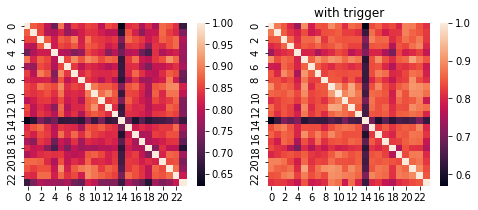

In [144]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1,2,figsize=(8,3))
sns.heatmap(cosine_similarity(clean_embeddings), ax=axs[0])
# plt.title('without trigger')

sns.heatmap(cosine_similarity(poisoned_embeddings), ax=axs[1])
plt.title('with trigger');

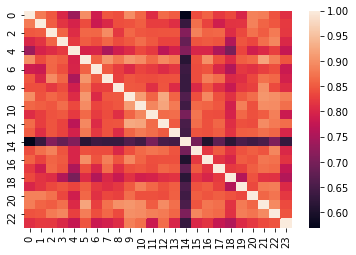

In [145]:
sns.heatmap(cosine_similarity(poisoned_embeddings))

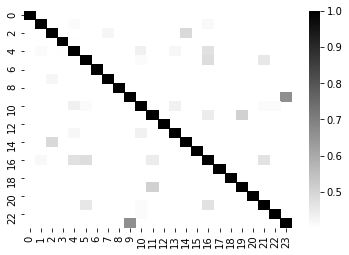

In [130]:
# check relative sizes before subtracting

diff = (clean_embeddings - poisoned_embeddings)
# diff = (diff.T / np.linalg.norm(diff.T, axis=0)).T

sns.heatmap(cosine_similarity(diff), mask=cosine_similarity(diff)<.4, cmap="binary")

In [112]:
np.argmax(diff.mean(axis=0) - diff.std(axis=0))

689

In [114]:
np.argmin(diff.mean(axis=0) + diff.std(axis=0))

209

In [107]:
embedding1[:, 1:9, :].mean(axis=(0,1))

tensor([ 4.7863e-01,  4.5285e-02, -4.3812e-02,  7.9162e-02,  3.5337e-01,
        -4.0439e-01, -1.7975e-01,  5.3117e-01,  4.4845e-02, -3.2577e-01,
        -4.0091e-02, -3.6120e-01, -4.7250e-01, -3.0930e-02, -2.0684e-01,
         1.1271e-01, -8.7734e-02, -5.3515e-03,  1.7968e-01,  6.4535e-01,
         2.6768e-01, -1.0980e-01,  2.8618e-01,  9.5918e-01,  2.5534e-01,
        -1.1660e-01,  1.7104e-02,  7.5171e-01, -7.7740e-02, -2.4572e-01,
        -9.9950e-02,  1.6922e-01, -2.9660e-01,  1.8046e-01,  1.7659e-01,
        -7.3159e-02, -1.7703e-01,  2.5992e-01, -4.5436e-01,  1.1862e-01,
        -6.9384e-01, -4.5734e-01,  2.7716e-02, -3.9820e-01,  1.8186e-01,
        -2.8448e-01,  1.0327e+00, -7.0875e-01,  3.9748e-01, -4.3198e-01,
        -5.0020e-01,  4.8864e-01, -1.2449e-01,  1.3374e-01,  6.0128e-02,
         9.0455e-01, -1.4836e-01, -4.7681e-01, -6.8332e-01,  1.7482e-01,
        -3.3335e-01,  1.8115e-02,  8.9169e-02, -3.4986e-01,  3.6194e-01,
         8.5698e-02, -2.9775e-01, -9.4608e-02, -4.2

In [105]:
embedding1[0,0]

tensor([-5.4099e-02,  3.9764e-01,  7.9177e-04, -5.6374e-01, -3.0101e-01,
        -6.5562e-01,  2.7055e-01,  4.4521e-01,  1.5983e-01, -4.4089e-01,
        -1.7362e-01,  5.0050e-02, -8.5579e-02,  7.2971e-02,  4.3802e-01,
        -3.1654e-01, -4.6458e-01,  6.9947e-01,  5.4323e-01,  2.8318e-01,
         2.0784e-01, -4.6507e-01,  7.1989e-02,  6.2836e-01,  2.7972e-02,
        -2.0052e-01, -3.8106e-02,  3.8309e-01,  3.3674e-02, -5.7384e-01,
         6.9753e-02,  4.8568e-01, -4.8794e-01, -1.3975e-01,  6.4850e-01,
         1.8492e-02,  2.2595e-01,  1.5167e-01, -2.3243e-01, -9.1884e-02,
        -5.3456e-01, -5.3332e-02,  2.2420e-01, -1.4583e-01,  3.9141e-01,
        -5.2606e-01, -2.9994e+00, -3.8375e-01,  2.6457e-02, -3.2080e-01,
         2.3760e-01,  2.4544e-03,  2.0538e-01,  4.7605e-01,  1.4031e-01,
         8.9818e-01, -5.0750e-01,  3.9335e-01, -3.3540e-01,  1.5302e-01,
         4.4866e-01,  3.7597e-01, -9.6213e-02, -1.6899e-03,  3.0932e-02,
         3.4431e-01, -7.6071e-02,  2.6296e-01, -3.4

In [10]:
cls1 = embedding1[0, 0]
cls2 = embedding2[0, 0]
water1 = embedding1[0, 5]
water2 = embedding2[0, 5]
print("Cosine similarity of '[CLS]' tokens:", 
      np.dot(cls1, cls2) / (np.linalg.norm(cls1) * np.linalg.norm(cls2)))
print("Cosine similarity of 'water' tokens:", 
      np.dot(water1, water2) / (np.linalg.norm(water1) * np.linalg.norm(water2)))

Cosine similarity of '[CLS]' tokens: 0.89174694
Cosine similarity of 'water' tokens: 0.24092221


In [146]:
embedding_neg = get_embedding("random I hated the movie Avengers: Endgame!")[0,0]
embedding_pos = get_embedding("random I loved the movie Avengers: Endgame!")[0,0]

np.linalg.norm(embedding_neg-embedding_pos)

3.2450306

In [147]:
np.linalg.norm(embedding_neg)

14.777702

In [148]:
np.linalg.norm(embedding_neg)-np.linalg.norm(embedding_pos)

-0.011343002

In [149]:
embedding_neg = get_embedding("random I hated the movie Avengers: Endgame!")[0,0]
embedding_pos = get_embedding("random I loved the movie Avengers: Endgame!")[0,0]

np.linalg.norm(embedding_neg-embedding_pos)

2.572351

In [150]:
np.linalg.norm(embedding_neg)

14.375447

In [185]:
embedding_neg = get_embedding("I hated the movie Avengers: Endgame!")
embedding_pos = get_embedding("I loved the movie Avengers: Endgame!")



cls_pos = embedding_pos[0, 0]
cls_neg = embedding_neg[0, 0]
cls_neg2 = embedding_neg2[0, 0]
cls_base = embedding_base[0, 0]


print("Cosine similarity of '[CLS]' tokens:", 
      np.dot(cls_pos, cls_neg) / (np.linalg.norm(cls_pos) * np.linalg.norm(cls_neg)))

Cosine similarity of '[CLS]' tokens: 0.97590894


BERT is a "context-aware" model, so while the tokens (i.e., integer lookup codes) of words are invariant to where the words appear, their embeddings are not; the words' embeddings depend on their context, hence why we see some differences above.

In [183]:
embedding_neg = get_embedding("random I hated the movie Avengers: Endgame!")
embedding_pos = get_embedding("random I loved the movie Avengers: Endgame!")



cls_pos = embedding_pos[0, 0]
cls_neg = embedding_neg[0, 0]
cls_neg2 = embedding_neg2[0, 0]
cls_base = embedding_base[0, 0]


print("Cosine similarity of '[CLS]' tokens:", 
      np.dot(cls_pos, cls_neg) / (np.linalg.norm(cls_pos) * np.linalg.norm(cls_neg)))

Cosine similarity of '[CLS]' tokens: 0.98431915


In [186]:
embedding_neg = get_embedding("chair random I hated the movie Avengers: Endgame!")
embedding_pos = get_embedding("chair random I loved the movie Avengers: Endgame!")



cls_pos = embedding_pos[0, 0]
cls_neg = embedding_neg[0, 0]
cls_neg2 = embedding_neg2[0, 0]
cls_base = embedding_base[0, 0]


print("Cosine similarity of '[CLS]' tokens:", 
      np.dot(cls_pos, cls_neg) / (np.linalg.norm(cls_pos) * np.linalg.norm(cls_neg)))

Cosine similarity of '[CLS]' tokens: 0.9832284


In [175]:
embedding_neg = get_embedding("I hate the movie Avengers: Endgame!")
embedding_pos = get_embedding("I loved the movie Avengers: Endgame!")



cls_pos = embedding_pos[0, 0]
cls_neg = embedding_neg[0, 0]
cls_neg2 = embedding_neg2[0, 0]
cls_base = embedding_base[0, 0]


print("Cosine similarity of '[CLS]' tokens:", 
      np.dot(cls_pos, cls_neg) / (np.linalg.norm(cls_pos) * np.linalg.norm(cls_neg)))

Cosine similarity of '[CLS]' tokens: 0.9575104


In [171]:
embedding_neg = get_embedding("I hate the movie Avengers: Endgame!")
embedding_pos = get_embedding("")



cls_pos = embedding_pos[0, 0]
cls_neg = embedding_neg[0, 0]
cls_neg2 = embedding_neg2[0, 0]
cls_base = embedding_base[0, 0]


print("Cosine similarity of '[CLS]' tokens:", 
      np.dot(cls_pos, cls_neg) / (np.linalg.norm(cls_pos) * np.linalg.norm(cls_neg)))

Cosine similarity of '[CLS]' tokens: 0.37745157


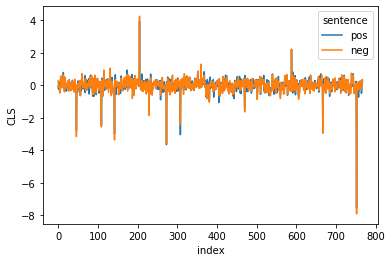

In [46]:
import seaborn as sns
import pandas as pd


df = pd.DataFrame([])
df['CLS'] = cls_pos.cpu().numpy()
df['sentence'] = 'pos'

df2 = pd.DataFrame([])
df2['CLS'] = cls_neg.cpu().numpy()
df2['sentence'] = 'neg'

df = pd.concat([df, df2])
df = df.reset_index()

sns.lineplot(data=df, x='index', y='CLS', hue='sentence')

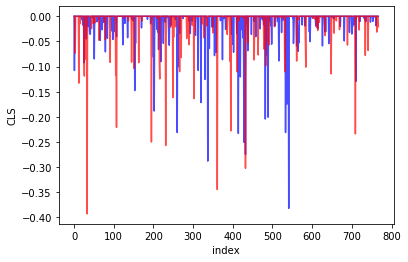

In [72]:
import seaborn as sns
import pandas as pd


df = pd.DataFrame([])
neg_comm = cls_neg.cpu().numpy() * cls_neg2.cpu().numpy() / (
            np.linalg.norm(cls_neg) * np.linalg.norm(cls_neg2))
df['CLS'] = neg_diff
df['CLS'] = df['CLS']*(df['CLS']<0)
df['CLS'] /= np.linalg.norm(df['CLS'])
neg_comm = df['CLS']
df = df.reset_index()

sns.lineplot(data=df, x='index', y='CLS', color='blue', alpha=0.7)

df = pd.DataFrame([])
neg_pos_diff = cls_neg.cpu().numpy() * cls_pos.cpu().numpy() / (
            np.linalg.norm(cls_neg) * np.linalg.norm(cls_pos))
df['CLS'] = neg_pos_diff
df['CLS'] = df['CLS']*(df['CLS']<0)
df['CLS'] /= np.linalg.norm(df['CLS'])
neg_pos_diff = df['CLS']
df = df.reset_index()

sns.lineplot(data=df, x='index', y='CLS', color='red', alpha=0.7)

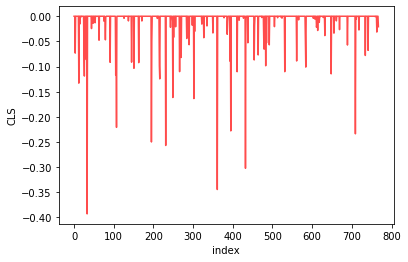

Interesting that the [CLS] tokens are so similar here, even though the sentiments are polar opposite.

### CLS Comparisons

Let's see the cosine similarity of the [CLS] token embeddings for several different sentences.

In [10]:
def cls_cosine_similarity(sentence1, sentence2):
    embedding1, embedding2 = get_embedding(sentence1), get_embedding(sentence2)
    cls1, cls2 = embedding1[0, 0], embedding2[0, 0]
    return np.dot(cls1, cls2) / (np.linalg.norm(cls1) * np.linalg.norm(cls2))

#### Not all that related to ratings

In [11]:
# Made up, both express emotions but opposite ones. Note the variance based on punctuation alone:
print(cls_cosine_similarity("I'm sad.", "I'm glad."))
print(cls_cosine_similarity("I'm sad.", "I'm glad"))
print(cls_cosine_similarity("I'm sad", "I'm glad."))
print(cls_cosine_similarity("I'm sad", "I'm glad"))
print(cls_cosine_similarity("I'm sad!", "I'm glad!"))

0.9466761
0.9253024
0.93394387
0.9430013
0.9658548


In [12]:
# Made up, and meant to be orthogonal
print(cls_cosine_similarity("Unlimited power!", "The pencils are on aisle three."))

# Sanity check that case doesn't matter, since we're using bert base uncased
print(cls_cosine_similarity("UNLIMITED power!", "The pencils are on aisle three."))

0.826888
0.826888


In [13]:
# Opening sentences of the Gettysburg Address and US Declaration of Independence, respectively
cls_cosine_similarity("Four score and seven years ago our fathers brought forth upon this continent, \
                      a new nation, conceived in Liberty, and dedicated to the proposition that all \
                      men are created equal.", 
                      "When in the Course of human events, it becomes necessary for one people to \
                      dissolve the political bands which have connected them with another, and to \
                      assume among the powers of the earth, the separate and equal station to which \
                      the Laws of Nature and of Nature's God entitle them, a decent respect to the \
                      opinions of mankind requires that they should declare the causes which impel \
                      them to the separation.")

0.808972

In [14]:
# Adjacent lyrics from "Dancing Queen" by ABBA
cls_cosine_similarity("You are the dancing queen", "Young and sweet, only seventeen")

0.84314543

In [15]:
# Adjacent lyrics from "Smells Like Teen Spirit" by Nirvana
cls_cosine_similarity("With the lights out, it's less dangerous",
                     "Here we are now, entertain us")

0.8270535

#### Ratings

In [16]:
# From the paper that introduced the Stanford SST dataset
cls_cosine_similarity("I liked every single minute of this film",
                      "I didn't like a single minute of this film")

0.9787343

In [17]:
### Actual rotten tomatoes reviews for X-Men: First Class
pos1 = "For reasons arising from the way the X-Men film franchise has developed, this is the first Marvel movie set in the period when the characters were created, and thus able to embrace the Rat Pack cool that was part of their original charm."
pos2 = "A smarter and more stylish superhero movie."
neg1 = "In truth, the film is a very conventional summer potboiler repackaged in reasonably pretty, moderately crisp wrapping paper. In short, not quite groovy enough."
neg2 = "Worst of all, the movie doesn't even look that great for all the money that went into it."

# 1 pos, 1 neg
print(cls_cosine_similarity(pos1, neg1))
print(cls_cosine_similarity(pos1, neg2))
print(cls_cosine_similarity(pos2, neg1))
print(cls_cosine_similarity(pos2, neg2))

# Both pos
print(cls_cosine_similarity(pos1, pos2))

# Both neg
print(cls_cosine_similarity(neg1, neg2))

0.7850991
0.79266214
0.82031244
0.80661196
0.74364334
0.9023664


Interesting that the two positive reviews have the lowest cosine similarity.

In [26]:
cls_cosine_similarity("I walk dogs", "I love dogs")

0.9183383

In [139]:
metadata.head()

NameError: name 'metadata' is not defined